# ML002 MNIST IMAGE CLASSIFICATION 

## 1. Understanding the Big Picture

In this project, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by igh school students and employees of the US Census Bureau. The purpose of the project is to understand how Machine Learning classification problems should be approached.

## 2. Getting the Data

### 2.1. Workspace Setup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler

### 2.2. Reading in the Data

Scikit-Learn provides many helper functions to download popular datasets, and MNIST is one of them. Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:
- A *DESCR* key describing the dataset
- A *data* key containing an array with one row per instance and column per feature
- A *target* key containing an array with the labels

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, Y = mnist["data"], mnist["target"]
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)

X.shape: (70000, 784)
Y.shape: (70000,)


### 2.3. Getting Familiar with the Data

There are 70,000 images, and each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0 (black) to 255 (white).

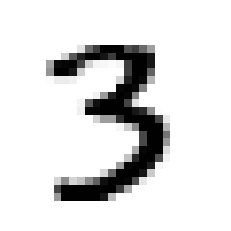

some_digit_label: 3
label_type: <class 'str'>


In [4]:
some_digit = X[10000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print("some_digit_label:", Y[10000])
print("label_type:", type(Y[10000]))

Above we printed some digit at X=10,000 which ended up being 3. To confirm that we also printed its label (Y) and it was confirmed that the digit is labeled as 3. Note that the lable is a string. Since we prefer numbers, let's cast Y to integers.

In [5]:
Y = Y.astype(np.int8)
print("Label_type has changed to:", type(Y[10000]))

Label_type has changed to: <class 'numpy.int8'>


### 2.4. Setting Aside a Test Set

The MNIST dataset is already split int a training set (first 60,000 images) and a test set (last 10,000).

In [6]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

Now, let's shuffle the training set to make sure that all our cross-validation folds are similar. We don't want one fold to be missing some digits. Also because some learning algorithms perform poorly if they get many similar instances in a row, shuffling ensures that this doesn't happen. 

In [7]:
shuffle_index = np.random.permutation(60000)
X_train, Y_train = X_train[shuffle_index], Y_train[shuffle_index]

## 3. Training a Model

### 3.1. Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit: 3. The "3-detector" will be an example of a *binary classifier*, capable of distinguishing between just two classes: 3 and not-3. Let's create the target vectors for this classification task:

In [8]:
Y_train_3 = (Y_train == 3)
Y_test_3 = (Y_test == 3)

A good place to start in picking a classifier to train is with a **Stochastic Gradient Descent (SGD)** classifier, using Scikit-Learn's *SGDClassifier*. It has the advantage of being capable of handling very large datasets efficiently due, in part, to the fact that SGD deals with training instances independently, one at a time. 

In [9]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, Y_train_3)
sgd_clf.predict([some_digit])

array([ True])

It looks like the classifier guessed that the image above (some_digit) represents a 3 (True), which is the right prediction.

### 3.2. Performance Measures

#### 3.2.1. Measuring Accuracy Using Cross-Validation

We can use the *cross_val_score()* function to evaluate our classifier model using K-fold cross-validation, with 5 folds. This means that we will be splitting the training set into 5 folds, and then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [10]:
cross_val_score(sgd_clf, X_train, Y_train_3, cv=5, scoring="accuracy")

array([0.96466667, 0.96516667, 0.96658333, 0.95733333, 0.96408333])

A 95% *accuracy* (ratio of correct predictions) on 4 out of 5 cross-validation folds seems abit too good to be true. That is because it not that hard to get a high score since only about 10% of the images are 3s. So if you always guess that an image is not 3, you will be right about 90% of the time. We are dealing with *skewed datasets* (when some classes are skewed more than others), and that means accuracy is generally not the preferred performance measure for classifiers.

#### 3.2.2. Confusion Matrix

A much better way is to use the *confusion matrix*, which counts the number of times instances of class A are classified as class B. We can use the *cross_val_predict() function* which also performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold

In [11]:
y_train_pred = cross_val_predict(sgd_clf, X_train, Y_train_3, cv=5)
y_train_pred

array([False, False, False, ..., False,  True, False])

In [12]:
confusion_matrix(Y_train_3, y_train_pred)

array([[52957,   912],
       [ 1274,  4857]], dtype=int64)

In [13]:
y_train_perfect_predictions = Y_train_3
confusion_matrix(Y_train_3, y_train_perfect_predictions)

array([[53869,     0],
       [    0,  6131]], dtype=int64)

Each row in a confusion matrix represents an actual class (non-3 and 3, in our case), while each column represents a predicted class. In our example above, of the 53,869 images of the first row that are actually non-3, 51,768 of them were correctly predicted as non-3 (*true negatives*), while 2,101 of them were incorrectly predicted as 3 when they should have been non-3 (*false positive*). The second row considers the images of 3s (the positive class): of 6,131 images, 5,106 were correctly classified as 3 (*true positives*), while 1,025 were incorrectly classified as non-3 (*false negatives*).

From this information we can calculate the **precision** of the classifier, which is the number of true positives divided by the sum of the number of true positives and false positives (precision = TP/(TP+FP)). We can also calculate the **recall** or *sensitivity*, which is the number of true positives divided by the sum of the true positives and the false negatives (recall = TP/(TP+FN)).

We can combine precision and recall into a single metric called the **F1 score**, which is the *harmonic mean* of precision and recall. The classifier will only get a high F1 score if both recall and precision are high.

In [14]:
precision_3 = precision_score(Y_train_3, y_train_pred)
recall_3 = recall_score(Y_train_3, y_train_pred)
f1_score_3 = f1_score(Y_train_3, y_train_pred)
print("Precision:", precision_3)
print("Recall:", recall_3)
print("F1_Score:", f1_score_3)

Precision: 0.8419136765470618
Recall: 0.7922035557005382
F1_Score: 0.8163025210084033


Turns out our "3-detector" isn't as shiny as it looked before when we only looked at its accurace. When it claims an image represents a 3, it is correct only **70.8%** of the time and it only detects **83.3%** of the 3s. The F1 score is **76.5%**.

**Note**: The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. 

#### 3.2.3. Precision/Recall Tradeoff

The SGDClassifier makes its classification decisions by computing a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class. Scikit-Learn does not let us set the threshold directly, but it does give us access to the decision scores that it uses to make predictions. This means we can get the scores of all instances in the training set using the *cross_val_predict() function*
again, but this time specifying that we want it to return *decision scores* instead of predictions. We can then use those scores to compute precision and recall for all possible thresholds.

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, Y_train_3, cv=5, 
                             method="decision_function")

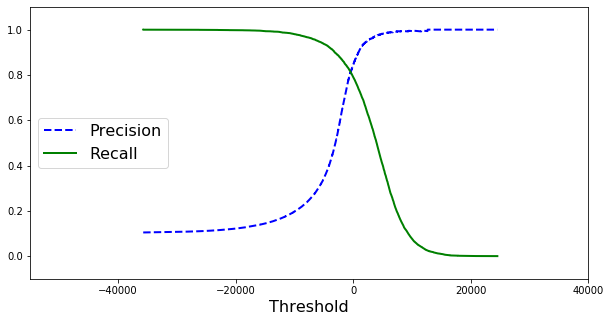

In [16]:
precisions, recalls, thresholds = precision_recall_curve(Y_train_3, y_scores)

def plot_prt(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center left", fontsize=16)
    plt.ylim([-0.1, 1.1])

plt.figure(figsize=(10, 5))
plot_prt(precisions, recalls, thresholds)
plt.xlim([-55000, 40000])
plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly against recall. 

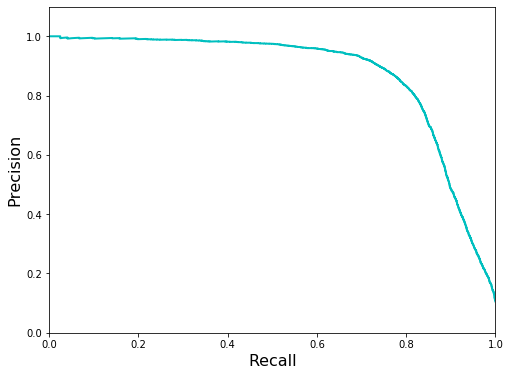

In [17]:
def plot_p_vs_r(precisions, recalls):
    plt.plot(recalls, precisions, "c-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1.1])

plt.figure(figsize=(8, 6))
plot_p_vs_r(precisions, recalls)
plt.show()

Now let's suppose we want to aim for a **90% precision** classifier:
- We can get the lowest threshold using the *np.argmax()* function
- Using that threshold, we can get the precision and rall scores

In [18]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
prec_3 = precision_score(Y_train_3, y_train_pred_90)
rec_3 = recall_score(Y_train_3, y_train_pred_90)
print("Precision:", prec_3)
print("Recall:", rec_3)
print("Threshold:", threshold_90_precision)

Precision: 0.9
Recall: 0.7398466808024792
Threshold: 900.9406057784697


Great, we now have a **90%-precision classifier** with a decent recall! Remember that a high-precision classifier is not very useful if its recall is too low! If someone says “let’s reach 99% precision,” you should ask, “at what recall?”

#### 3.2.4. The ROC Curve

The *receiver operating characteristic (ROC)* curve plots the *true positive rate*, TPR (another name for recall) against the *false positive rate*, FPR.

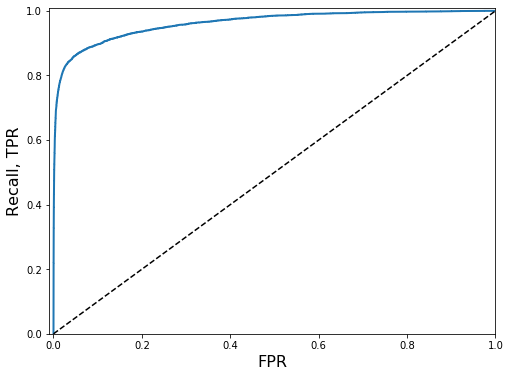

In [19]:
fpr, tpr, thresholds = roc_curve(Y_train_3, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1.01])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('Recall, TPR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

In [20]:
roc_auc = roc_auc_score(Y_train_3, y_scores)
print("ROC_AUC:", roc_auc)

ROC_AUC: 0.9622123677712884


### 3.3. Random Forest vs. SGD

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. 
- First, we need to get scores for each instance in the training set. But the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. 
- We will use Random Forest's probabilities of positive class as scores
- We will then plot ROC curves for comparison.

In [21]:
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, Y_train_3, cv=5,
                                    method="predict_proba")

y_scores_forest = y_prob_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_train_3, y_scores_forest)

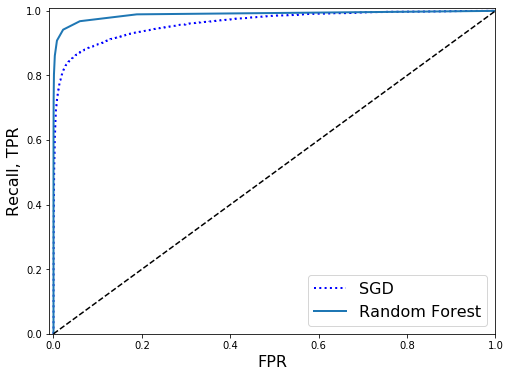

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [23]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, Y_train_3, cv=5)

In [24]:
forest_roc_auc = roc_auc_score(Y_train_3, y_scores_forest)
forest_precision = precision_score(Y_train_3, y_train_pred_forest)
forest_recall = recall_score(Y_train_3, y_train_pred_forest)
print("Forest_ROC_AUC:", forest_roc_auc)
print("Forest_Precision:", forest_precision)
print("Forest_Recall:", forest_recall)

Forest_ROC_AUC: 0.9889380803008164
Forest_Precision: 0.9887527615987146
Forest_Recall: 0.8029685206328494


The RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better. A 98.6% precision with a 79.1% recall isn't bad either. 

### 3.4. Multiclass Classification

There are two kinds of *multiclass classifiers* (also called *multinomial classifiers*) available for us:
- **OvA** or *one-versus-all*: train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on).
- **OvO** or *one-versus-one*:  train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.

Some algorithms do poorly with one strategy and better with the other. 

#### 3.4.1. OvA SGD Classifier

In [25]:
sgd_clf.fit(X_train, Y_train)  # Y_train, not Y_train_3
sgd_clf.predict([some_digit])
some_digit_scores = sgd_clf.decision_function([some_digit])

The code above trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score. Instead of returning just one score per instance, it now returns 10 scores, one per class. The highest score is indeed the one corresponding to class 3. 

In [26]:
some_digit_scores

array([[-26151.97629148, -30885.05019623, -12583.29811717,
          5273.24251983, -13195.7749511 ,  -7506.5667855 ,
        -38928.12265861,  -5736.6259185 ,  -5920.09981267,
        -19688.19750409]])

In [27]:
np.argmax(some_digit_scores)

3

In [28]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [29]:
sgd_clf.classes_[3]

3

In [30]:
cross_val_score(sgd_clf, X_train, Y_train, cv=3, scoring="accuracy")

array([0.8696, 0.8893, 0.869 ])

#### 3.4.2. OvO SGD Classifier

In [31]:
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, Y_train)
ovo_clf.predict([some_digit])

array([3], dtype=int8)

In [32]:
len(ovo_clf.estimators_)

45

#### 3.4.3. Random Forest Classifier

Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. 

In [33]:
forest_clf.fit(X_train, Y_train)
forest_clf.predict([some_digit])
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

We can see that the classifier is fairly confident about its prediction: the 1. at the 3rd index in the array means that the model estimates a 100% probability that the image represents a 3.

## 4. Fine-Tuning Model: Error Analysis

**Ways to improve our model**: One way is to analyze the types of errors it makes. First, we can look at the confusion matrix. We need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function, just like we did earlier.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, Y_train, cv=3, scoring="accuracy")

# Jupyter is taking forever to running some of these codes! Will stop here for now...